In [1]:
import nilearn
from nilearn import datasets, plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import MultiNiftiLabelsMasker
import os
import requests
import csv
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import scipy
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics.cluster import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from collections import deque, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [2]:
home_base_dir = '/Users/aj/dmello_lab/fmri_connectivity_trees' # directory where repository lives at home computer
lab_base_dir = '/Users/ajjain/Downloads/Code/fmri_connectivity_trees' # directory where repository lives at lab computer

# set base directory depending on where the code is being run
base_dir = home_base_dir if os.path.exists(home_base_dir) else lab_base_dir

# get msdl and whole brain atlases and coords
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

# get schaefer
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
schaefer_coords = plotting.find_parcellation_cut_coords(labels_img=schaefer.maps)

# concatenate timeseries to get a single timeseries for each subject
def get_timeseries(ids, cort_shape_path, cort_pooled_path):
    timeseries = []
    for id in ids:

        # load the shape and pooled timeseries
        shape = np.loadtxt(f'{cort_shape_path}/{id}.csv', delimiter=',').astype(int)
        pooled = np.loadtxt(f'{cort_pooled_path}/{id}.csv', delimiter=',').reshape(shape)

        # concatenate the timeseries
        timeseries.append(pooled)

    return timeseries

# path for shapes and pooled timeseries
subjects = [
            'MSC01', 
            'MSC03'
            ]
sessions = ['func01', 'func02', 'func03', 'func04', 'func05', 'func06', 'func07', 'func08', 'func09', 'func10']
ids = ['motor_run-01', 'motor_run-02']
atlas = 'Schaefer'

motor_timeseries = {}
for subject in subjects:
    cort_shape_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/func01/{atlas}/all_tasks/shape/'
    cort_pooled_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/func01/{atlas}/all_tasks/pooled/'
    motor_timeseries[subject] = get_timeseries(ids, cort_shape_path, cort_pooled_path)
    for session in sessions[1:]:
        cort_shape_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/{session}/{atlas}/all_tasks/shape/'
        cort_pooled_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/{session}/{atlas}/all_tasks/pooled/'
        motor_timeseries[subject] = motor_timeseries[subject] + get_timeseries(ids, cort_shape_path, cort_pooled_path)

[get_dataset_dir] Dataset found in /Users/ajjain/nilearn_data/msdl_atlas
[get_dataset_dir] Dataset found in /Users/ajjain/nilearn_data/schaefer_2018


In [3]:
sub1_concat = np.concatenate(motor_timeseries['MSC01'], axis=0).T
sub2_concat = np.concatenate(motor_timeseries['MSC03'], axis=0).T

In [4]:
def get_covariance(concat_timeseries):
    """
    Get the covariance matrix of the concatenated timeseries.
    """
    # get the covariance matrix
    cov = np.cov(concat_timeseries)

    for i in range(len(cov)):
        for j in range(len(cov)):
            if i == j:
                cov[i][j] = 0

    return cov

# get covariance matrices
sub1_cov = get_covariance(sub1_concat) # sub1 covariance matrix
sub2_cov = get_covariance(sub2_concat) # sub2 covariance matrix

In [5]:
def plot_connectome(cov_matrix, coords, title='connectome', edge_threshold="0%", edge_vmin=0, edge_vmax=1):
    """
    Plot the connectome using the mean correlation matrix and coordinates.
    """
    # Plotting the connectome
    plotting.plot_connectome(
        cov_matrix,
        coords,
        title=title,
        edge_vmin = edge_vmin,
        edge_vmax = edge_vmax,
        edge_cmap='cold_hot',
        edge_threshold=edge_threshold,  # Only plot edges above the 90th percentile
        colorbar=True,
        node_size=10,
    )
    plt.show()

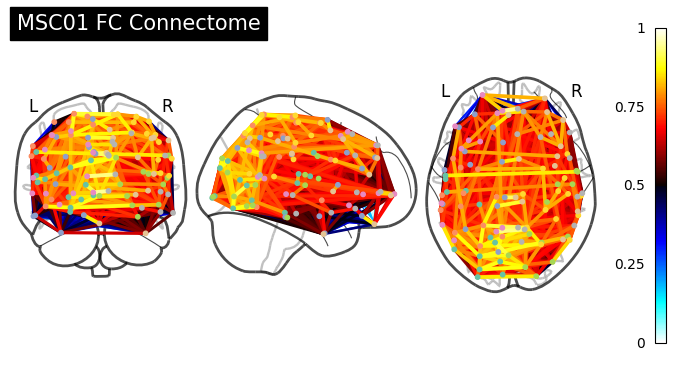

In [6]:
plot_connectome(sub1_cov, schaefer_coords, title='MSC01 FC Connectome', edge_threshold="0%")

In [21]:
atlas_subdir = 'schaefer_100'

# save matrices to csv
sub1_cov_df = pd.DataFrame(sub1_cov)
sub1_cov_df.to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/covariance/msc01/{atlas_subdir}/motor.csv', index=False)
sub2_cov_df = pd.DataFrame(sub2_cov)
sub2_cov_df.to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/covariance/msc03/{atlas_subdir}/motor.csv', index=False)

In [30]:
sub1_concat.shape

(100, 2080)

In [8]:
# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

# create masker using MultiNiftiLabelsMasker to extract functional data within
# atlas parcels from multiple subjects using parallelization to speed up the
# computation
masker = MultiNiftiLabelsMasker(
    labels_img=schaefer.maps,  # Both hemispheres
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    n_jobs=2,
)


# calculate correlation matrices across subjects and display
correlation_matrices_sub1 = connectome_measure.fit_transform([sub1_concat.T])
sub1_corr = connectome_measure.mean_

correlation_matrices_sub2 = connectome_measure.fit_transform([sub2_concat.T])

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
sub2_corr = connectome_measure.mean_

In [9]:
atlas_subdir = 'schaefer_100'
pd.DataFrame(sub1_corr).to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/connectome_corr/msc01/{atlas_subdir}/motor.csv', index=False)
pd.DataFrame(sub1_corr).to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/connectome_corr/msc03/{atlas_subdir}/motor.csv', index=False)

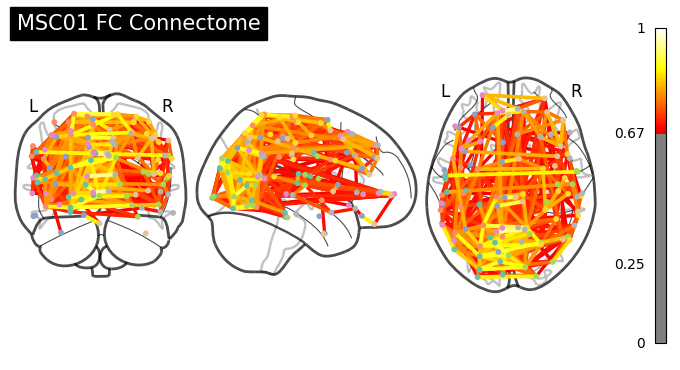

In [10]:
# also color code these connections based on motor, visual, etc.
plot_connectome(sub1_corr, schaefer_coords, title='MSC01 FC Connectome', edge_threshold="90%")

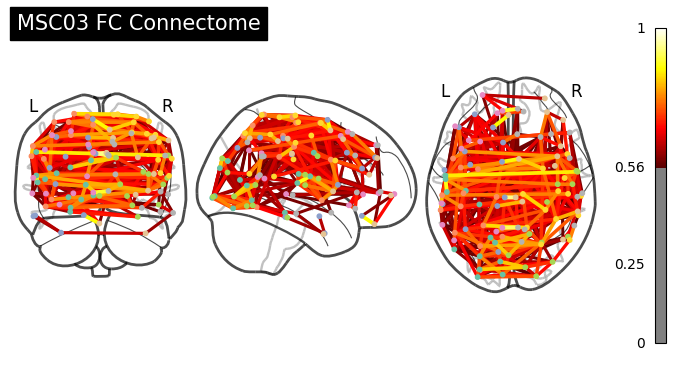

In [13]:
plot_connectome(sub2_cov, schaefer_coords, title='MSC03 FC Connectome', edge_threshold="90%")

In [14]:
def mutual_information_continuous(x, y, bins=10):
    """
    Estimate mutual information between two continuous variables by discretizing them.

    Parameters:
    x (array-like): First continuous variable.
    y (array-like): Second continuous variable.
    bins (int): Number of bins to use for discretization.

    Returns:
    float: Estimated mutual information.
    """
    # Convert to pandas Series
    x = pd.Series(x)
    y = pd.Series(y)

    # Discretize the continuous values
    x_binned = pd.cut(x, bins=bins, labels=False)
    y_binned = pd.cut(y, bins=bins, labels=False)

    # Compute contingency table
    contingency_table = pd.crosstab(x_binned, y_binned)

    # Compute mutual information
    mi = mutual_info_score(None, None, contingency=contingency_table.values)

    return mi

def get_mutual_info(timeseries, bins=100):

    mutual_info_matrix = np.zeros((timeseries.shape[1], timeseries.shape[1]))

    # get mutual information
    for region in range(timeseries.shape[1]):
        for region2 in range(timeseries.shape[1]):
            if region != region2:
                mutual_info = mutual_information_continuous(timeseries[:, region], timeseries[:, region2], bins=bins)
                mutual_info_matrix[region, region2] = mutual_info
    
    return mutual_info_matrix

In [12]:
# try all timepoints, 10 bins
sub1_mutual_info = get_mutual_info(sub1_concat.T, bins=10)
sub1_mi_df = pd.DataFrame(sub1_mutual_info)
sub1_mi_df.to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/msc01/schaefer_100/10bin_motor.csv', index=False)

In [15]:
sub2_mutual_info = get_mutual_info(sub2_concat.T, bins=10)
sub2_mi_df = pd.DataFrame(sub2_mutual_info)
sub2_mi_df.to_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/msc03/msdl/10bin_motor.csv', index=False)

In [16]:
# load the saved matrices
sub1_mutual_info = pd.read_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/msc01/schaefer_100/10bin_motor.csv').to_numpy()
sub2_mutual_info = pd.read_csv(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/msc03/msdl/10bin_motor.csv').to_numpy()

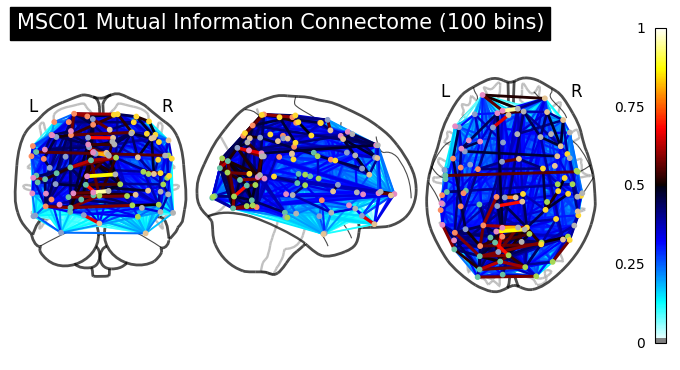

In [17]:
plot_connectome(sub1_mutual_info, schaefer_coords, title='MSC01 Mutual Information Connectome (100 bins)', edge_vmin=0, edge_threshold="0%")

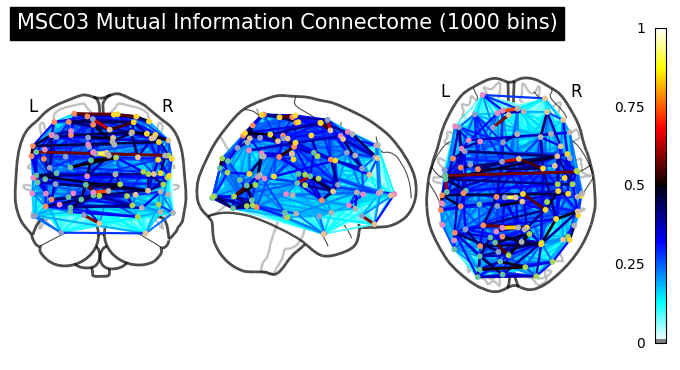

In [19]:
plot_connectome(sub2_mutual_info, schaefer_coords, title='MSC03 Mutual Information Connectome (1000 bins)', edge_threshold="0%")

In [20]:
# Construct the Chow-Liu tree from continuous data using mutual information.
def get_chow_liu_tree(timeseries, mi_matrix=None, bins=1000):
    
    # Compute the mutual information matrix
    if mi_matrix is None:
        mi_matrix = get_mutual_info(timeseries, bins=bins)

    # Set the diagonal to zero (self-information)
    np.fill_diagonal(mi_matrix, 0)

    # We use the negative MI because scipy's minimum_spanning_tree computes *minimum* tree.
    mst = minimum_spanning_tree(-mi_matrix).toarray()

    # Make MST undirected and remove negative sign
    mst = -mst + (-mst).T

    # Create NetworkX graph for visualization or further use
    G = nx.Graph()
    n = mi_matrix.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            if mst[i, j] != 0:
                G.add_edge(i, j, weight=mi_matrix[i, j])
    
    return G, mst

In [22]:
G_sub1, mst_sub1 = get_chow_liu_tree(sub1_concat, mi_matrix=sub1_mutual_info)
G_sub2, mst_sub2 = get_chow_liu_tree(sub2_concat, mi_matrix=sub2_mutual_info)

In [24]:
mst_sub1

array([[-0.        , -0.        ,  0.43734001, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.43734001, -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]], shape=(100, 100))

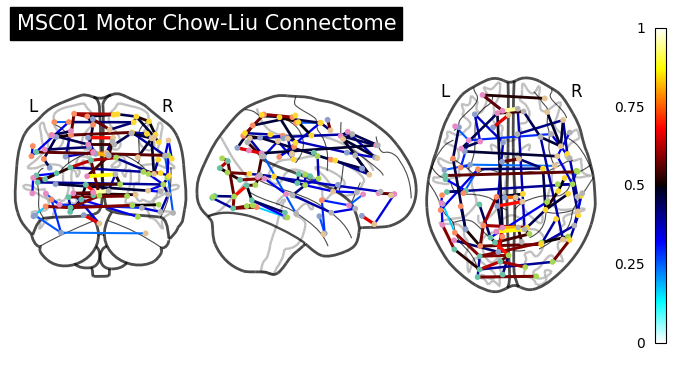

In [24]:
# identify clusters through color coding
plot_connectome(mst_sub1, schaefer_coords, title='MSC01 Motor Chow-Liu Connectome', edge_threshold="0%")

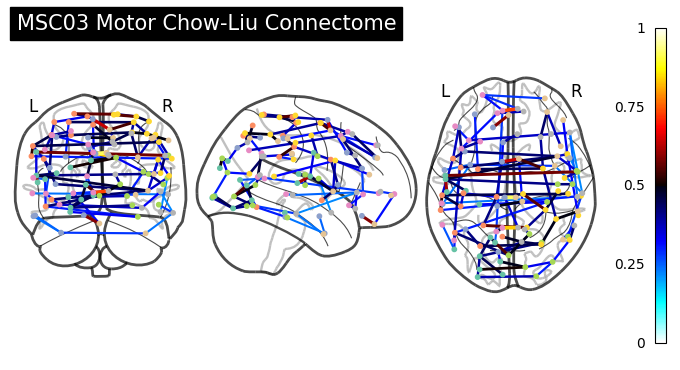

In [25]:
plot_connectome(mst_sub2, schaefer_coords, title='MSC03 Motor Chow-Liu Connectome', edge_threshold="0%")

In [26]:
def draw_chow_liu_tree(G, root=0):
    """
    Visualize the Chow-Liu tree using a spring layout (no pygraphviz).
    """
    tree = nx.bfs_tree(G, source=root)
    pos = nx.spring_layout(tree, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, arrows=True, node_color="lightblue", 
            edge_color="black", node_size=1500, font_size=12)
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels)

    plt.title("Chow-Liu Tree (Spring Layout)")
    plt.axis("off")
    plt.show()

def hierarchy_pos(G, root=None, width=1., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Hierarchical layout for directed trees. Assigns space to subtrees to avoid squishing.
    """
    def _count_descendants(G, node):
        children = list(G.successors(node))
        if not children:
            return 1
        return sum(_count_descendants(G, child) for child in children)

    def _hierarchy_pos(G, node, left, right, vert_loc, pos):
        center = (left + right) / 2
        pos[node] = (center, vert_loc)
        children = list(G.successors(node))
        if children:
            total = sum(_count_descendants(G, child) for child in children)
            dx = (right - left) / total
            next_left = left
            for child in children:
                size = _count_descendants(G, child)
                next_right = next_left + dx * size
                pos = _hierarchy_pos(G, child, next_left, next_right, vert_loc - vert_gap, pos)
                next_left = next_right
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_loc, {})

def get_node_regions(tree):

    networks = []
    for node in tree.nodes:
        network = str(schaefer.labels[node]).split('_')[2]
        networks.append(network)
    return networks

def draw_hierarchical_tree(G, root=0, title = "Hierarchical Chow-Liu Tree"):
    """
    Draw Chow-Liu tree in a hierarchical top-down format.
    """
    # Ensure it's a directed tree rooted at `root`
    tree = nx.bfs_tree(G, source=root)

    pos = hierarchy_pos(tree, root)

    networks = get_node_regions(tree)

    # Create a color map based on the networks
    color_map = []
    network_names = ['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']

    for node, network in zip(tree.nodes, networks):
        if network in network_names:
            color_map.append(colors[network_names.index(network)])
        else:
            color_map.append(0)
    
    # color_map = np.array(color_map)
    # color_map = color_map / max(color_map)
    
    plt.figure(figsize=(10, 6))
    nx.draw(tree, pos, with_labels=True, node_color=color_map, node_size=140,
            arrows=True, font_size=6, edge_color='gray')


    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    # nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size = 0)

    patches = [mpatches.Patch(color=color, label=network_name) for color, network_name in zip(colors, network_names)]
    plt.legend(handles=patches)

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

    return tree, pos, network_names, colors

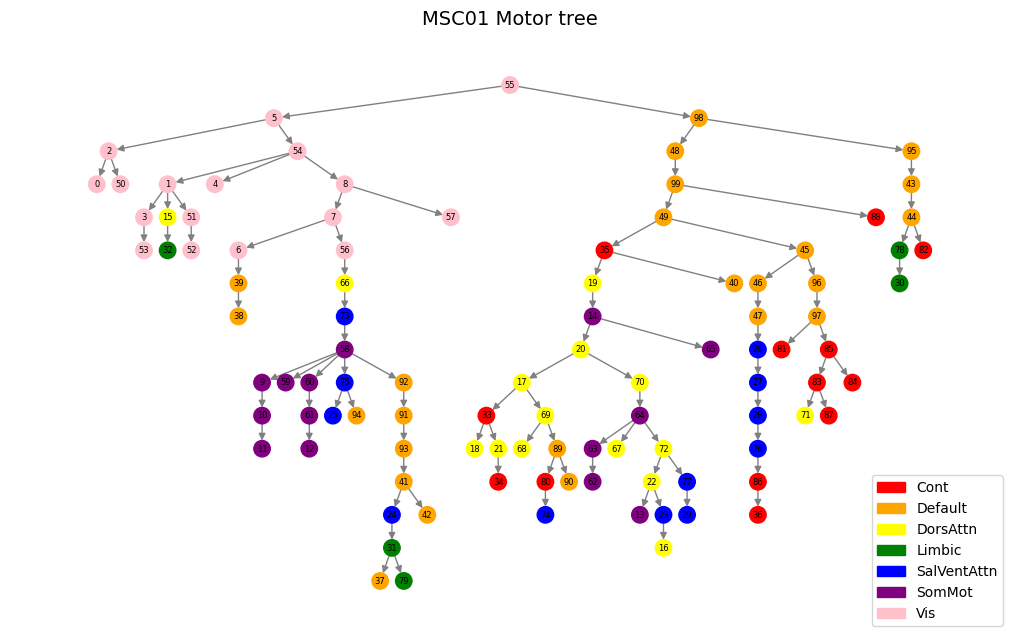

In [27]:
tree, pos, network_names, colors = draw_hierarchical_tree(G_sub1, root=55, title="MSC01 Motor tree")
# visual process in parallel with default to process the task
# vision guided process, default mentalizes internal processes not dependent on internal stimuli
# hierarchical process from lower level to higher level function
# external stimuli processing --> response
# left is processes relevant to external stimuli, right is more internal cross-modal processing

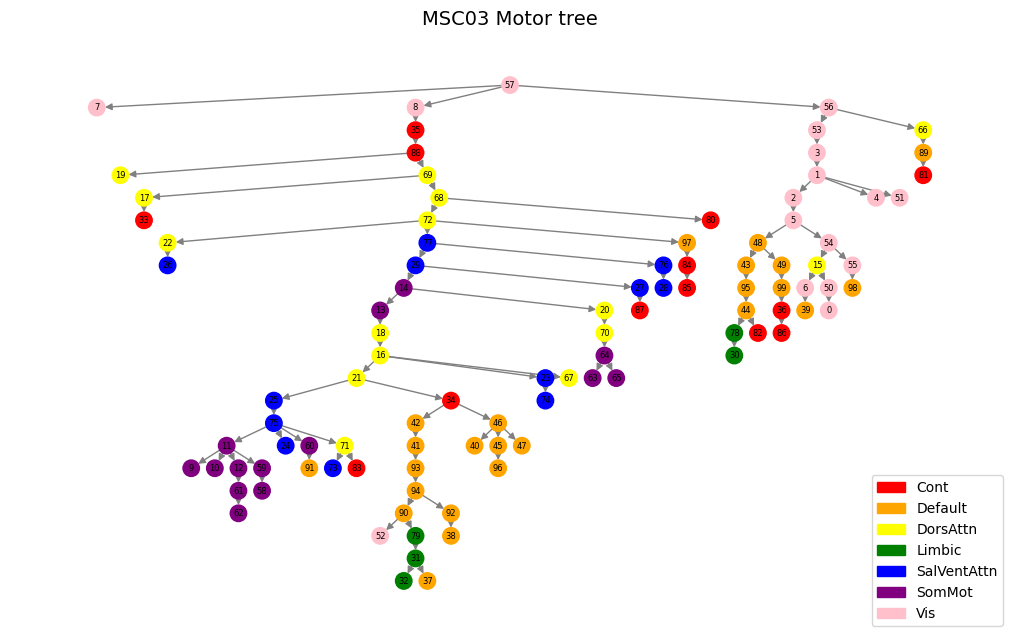

In [33]:
tree, pos, network_names, colors = draw_hierarchical_tree(G_sub2, root=57, title="MSC03 Motor tree")

In [109]:
schaefer.labels[86]

np.bytes_(b'7Networks_RH_Cont_Cing_1')

In [89]:
print(network_names)
print(colors)

['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']
[0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]


In [45]:
str(schaefer.labels[20]).split('_')[2]

'DorsAttn'

In [50]:
tree.nodes

NodeView((55, 5, 98, 2, 54, 48, 95, 0, 50, 1, 4, 8, 99, 43, 3, 15, 51, 7, 57, 49, 88, 44, 53, 32, 52, 6, 56, 35, 45, 78, 82, 39, 66, 19, 40, 46, 96, 30, 38, 73, 14, 47, 97, 58, 20, 65, 26, 81, 85, 9, 59, 60, 75, 92, 17, 70, 27, 83, 84, 10, 61, 25, 94, 91, 33, 69, 64, 28, 71, 87, 11, 12, 93, 18, 21, 68, 89, 63, 67, 72, 76, 41, 34, 80, 90, 62, 22, 77, 86, 24, 42, 74, 13, 23, 29, 36, 31, 16, 37, 79))

In [72]:
networks

['Vis',
 'Vis',
 'Default',
 'Vis',
 'Vis',
 'Default',
 'Default',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Default',
 'Default',
 'Vis',
 'DorsAttn',
 'Vis',
 'Vis',
 'Vis',
 'Default',
 'Cont',
 'Default',
 'Vis',
 'Limbic',
 'Vis',
 'Vis',
 'Vis',
 'Cont',
 'Default',
 'Limbic',
 'Cont',
 'Default',
 'DorsAttn',
 'DorsAttn',
 'Default',
 'Default',
 'Default',
 'Limbic',
 'Default',
 'SalVentAttn',
 'SomMot',
 'Default',
 'Default',
 'SomMot',
 'DorsAttn',
 'SomMot',
 'SalVentAttn',
 'Cont',
 'Cont',
 'SomMot',
 'SomMot',
 'SomMot',
 'SalVentAttn',
 'Default',
 'DorsAttn',
 'DorsAttn',
 'SalVentAttn',
 'Cont',
 'Cont',
 'SomMot',
 'SomMot',
 'SalVentAttn',
 'Default',
 'Default',
 'Cont',
 'DorsAttn',
 'SomMot',
 'SalVentAttn',
 'DorsAttn',
 'Cont',
 'SomMot',
 'SomMot',
 'Default',
 'DorsAttn',
 'DorsAttn',
 'DorsAttn',
 'Default',
 'SomMot',
 'DorsAttn',
 'DorsAttn',
 'SalVentAttn',
 'Default',
 'Cont',
 'Cont',
 'Default',
 'SomMot',
 'DorsAttn',
 'SalVentAttn',
 'Cont',
 'SalV

In [ ]:
networks = []
for node in tree.nodes:
    network = str(schaefer.labels[node]).split('_')[2]
    print(f"Node {node}: {network}")
    networks.append(network)

In [62]:
set(networks)

{'Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis'}

In [38]:
# lower to higher level
# color code with organizations
schaefer.labels[20]

np.bytes_(b'7Networks_LH_DorsAttn_Post_6')

In [39]:
schaefer.labels[17]

np.bytes_(b'7Networks_LH_DorsAttn_Post_3')

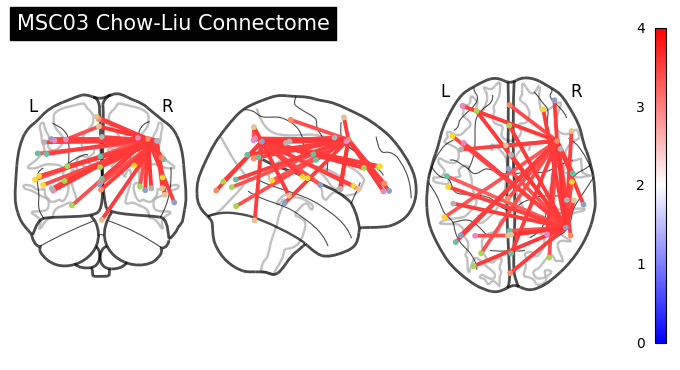

In [41]:
plot_connectome(mst_sub2, msdl_coords, title='MSC03 Chow-Liu Connectome', edge_vmin=0, edge_vmax=4, edge_threshold="0%")